<a href="https://colab.research.google.com/github/JeremyQuijano/ph582_final_project_group_f/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [4]:
%cd gdrive/Shareddrives/ML\ project  # change it to the path containing m12f folder https://drive.google.com/drive/folders/1DcmgGiFeJaOAw_6Ogk8Pujg51yNAYNmO?usp=sharing

/content/gdrive/Shareddrives/ML project


In [ ]:
# !zip -r /content/gdrive/Shareddrives/ML\ project/m12f.zip /content/gdrive/Shareddrives/ML\ project/m12f 

In [ ]:
!pip install umap-learn

# Import libraries

In [34]:
import gizmo_analysis as gizmo
import utilities as ut
import os
import matplotlib
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ImageNormalize, LogStretch
import umap
from time import time
from sklearn.manifold import TSNE
from scipy.interpolate import UnivariateSpline, interp1d
from astropy.convolution import Gaussian1DKernel, convolve
from sklearn.cluster import DBSCAN

In [6]:
matplotlib.rcParams['xtick.labelsize'] = 11
matplotlib.rcParams['ytick.labelsize'] = 11
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 13   
matplotlib.rcParams['axes.titlesize'] = 20  

# Functions to plot results and calculate some stellar properties

In [7]:
def plot_results(data, c, clabel, xlabel='t-SNE 2d - one', ylabel='t-SNE 2d - two', **kw):
    if 'clim' in kw:
        vmin, vmax = kw['clim']
    else:
        vmin, vmax = [np.min(c), np.max(c)]
    if data.shape[1] == 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(data[:, 0], data[:, 1], c=c, cmap='Spectral', s=1, vmin=vmin, vmax=vmax)
        plt.gca().set_aspect('equal', 'datalim')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.colorbar(label=clabel)
        if 'method' in kw:
            plt.title(kw['method'], fontsize=11)
        if 'fname' in kw:
            plt.tight_layout()
            plt.savefig(kw['fname']+'.png', dpi=120)
        plt.show()
        plt.close()

In [21]:
def limits(data, low=0.001, high=0.999, bins=200, **kwargs):
    if len(data) == 0:
        return [0, 0]
    if min(data) == max(data):
        return [0, 0]
    lim_min, lim_max = [np.percentile(data, low), np.percentile(data, high)]
    return [lim_min, lim_max]

def parse_limits(lim_input, data):
    if not isinstance(lim_input, str):
        real_lim = lim_input
    else:
        if '%' in lim_input:
            if lim_input.split('%')[-1] == '':
                low = float(lim_input.split('%')[0])
                percents = [low/100, 1-low/100]
            else:
                percents = [float(elem)/100 for elem in lim_input.split('%')]
        else:
            percents = [0.01, 0.99]

        if len(data) == 1:
            real_lim = limits(data[0], low=percents[0], high=percents[-1])
        else:
            real_lim = [limits(data[0], low=percents[0], high=percents[-1]),
                        limits(data[1], low=percents[0], high=percents[-1])]
    return real_lim

def density_plot(x, y, xlabel='x', ylabel='z', title='stellar disk', clabel='Number of points per pixel', name='xz.png',
                 figsize=(12, 8), cbar_flag=True, **kwargs):

    if ('clim' in kwargs) and ('c' in kwargs):
        climits = parse_limits(kwargs.get('clim'), [kwargs.get('c')])
    elif 'clim' in kwargs:
        climits = kwargs.get('clim')
    else:
        climits = [0, 750]

    if 'axlim' in kwargs:
        lim = parse_limits(kwargs.get('axlim'), [x, y])
        if np.shape(lim) == (2,):
            xlimits = lim
            ylimits = lim
        else:
            xlimits, ylimits = lim
    else:
        xlimits = limits(np.ravel(x))
        ylimits = limits(np.ravel(y))

    if 'stretch' in kwargs:
        if kwargs.get('stretch') == 'log':
            if climits[0] == 0:
                climits[0] += 1
            norm = colors.LogNorm(vmin=climits[0], vmax=climits[1])
        elif kwargs.get('stretch') == 'lin':
            norm = colors.Normalize(vmin=climits[0], vmax=climits[1])
    else:
        norm = colors.LogNorm(vmin=climits[0], vmax=climits[1])

    if 'cmap' in kwargs:
        cmap=plt.get_cmap(kwargs.get('cmap'))
    else:
        cmap=plt.get_cmap('Blues')

    if 'bins' in kwargs:
        bins = kwargs.get('bins')  # should be different at x and y?
    else:
        bins = 1024

    fig = plt.figure()
    fig.subplots_adjust(left=0.2)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel) 
    ax.set_title(title)
    if 'c' in kwargs:
      hist = np.histogram2d(x, y, bins=bins, range=[[xlimits[0], xlimits[1]],[ylimits[0], ylimits[1]]])
      hist_weights = np.histogram2d(x, y, bins=bins, range=[[xlimits[0], xlimits[1]], [ylimits[0], ylimits[1]]],
                                      weights=kwargs.get('c'))
      dens = ax.imshow((hist_weights[0]/hist[0]).T, origin='lower',
                             extent=[xlimits[0], xlimits[1], ylimits[0], ylimits[1]], cmap=cmap, norm=norm, aspect='auto')
    else:
      hist = np.histogram2d(x, y, bins=bins, range=[[xlimits[0], xlimits[1]],[ylimits[0], ylimits[1]]])
      dens = ax.imshow(hist[0].T, origin='lower', extent=[xlimits[0], xlimits[1], ylimits[0], ylimits[1]], cmap=cmap,
                         norm=norm, aspect='auto')

    if cbar_flag:
        cbar = plt.colorbar(dens, orientation='vertical', fraction=0.1, aspect=60, label=clabel)
        cbar.ax.tick_params(labelsize=8)
    plt.show()
    fig.savefig(name, dpi=320) 
    plt.close()

In [9]:
def ang_mom(r, v):
    '''
    :param r: vector of coordinates
    :param v: vector of velocities
    :return: vector of angular momentum
    '''
    jz = r[0]*v[1] - r[1]*v[0]
    jy = -r[0]*v[2] + r[2]*v[0]
    jx = r[1]*v[2] - r[2]*v[1]
    return [jx, jy, jz]


def ang_mom_circ(r, v, phi, rmax=200, bins=100):
    '''
    :param r: radius
    :param v: total velocity
    :param phi: potential
    :return: j_circ(E)
    '''
    r_phi = np.array(sorted([x for x in zip(r, phi)]))
    r_edges = np.linspace(0, rmax, bins+1)  # check what is max(r); should I apply limits?
    r_bin = 0.5*(r_edges[1:] + r_edges[:-1])
    phi_bin = np.zeros_like(r_bin)

    for i in range(len(r_bin)-1):
        idxs_bin = np.where((r_phi.T[0] > r_edges[i]) & (r_phi.T[0] < r_edges[i+1]))
        phi_bin[i] = np.mean(r_phi.T[1][idxs_bin])

    phi_spl = UnivariateSpline(r_bin, phi_bin)
    phi_der = phi_spl.derivative()

    # j(E) interpolation
    r = np.linspace(0, rmax, 1000)
    j_circ_E_spl = interp1d(0.5 * r * phi_der(r) + phi_spl(r), np.sqrt(r * phi_der(r)) * r,
                        fill_value=0, bounds_error=False)

    j_circ_E = j_circ_E_spl(0.5 * v ** 2 + phi)

    return j_circ_E

# Read snapshots from path/output directory

In [10]:
part = gizmo.io.Read.read_snapshots(['star'], 'index', 600,
   	                                simulation_directory='m12f', 
                                    assign_host_principal_axes=True,  # assgin host principal axis — to put 0 of coords to host galaxy center
                                    assign_formation_coordinates=True) # to track formation coordinates  


# in utilities.simulation.Snapshot():
* reading:  m12f/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  m12f/output/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 96239056 particles
    dark2     (id = 2): 7591203 particles
    gas       (id = 0): 80307825 particles
    star      (id = 4): 16066489 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

! cannot find MUSIC config file:  m12f/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA box):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties
! warning: star id.child [min, max] = [0.000, 4.289e9]
! warning: star mass [min, med, max] = [3307.548, 5390.065, 5456

# Divide dataset into sample A ($R_{birth}$ < 20 kpc) and sample B (30 <$R_{birth}$ < 500 kpc)

In [11]:
idxs_star = np.where(part['star'].prop('host.distance.principal.total')<20)  #sample A
# idxs_star = np.where((part['star'].prop('host.distance.principal.total')>30) & (part['star'].prop('host.distance.principal.total')<500))  #sample B
print('Number of stars in the sample: ', len(idxs_star[0]))

Number of stars in the sample:  14169142


In [12]:
# define arrays with stellar properties and take every k-th star to decrease sample size and speed up calculations
k = 1000 # for sample A
# k = 100 # for sample B  
feh = part['star'].prop('metallicity.fe')[idxs_star][::k]
ofe = part['star'].prop('metallicity.o-metallicity.fe')[idxs_star][::k]
mgfe = part['star'].prop('metallicity.mg-metallicity.fe')[idxs_star][::k]
sife = part['star'].prop('metallicity.si-metallicity.fe')[idxs_star][::k]
cafe = part['star'].prop('metallicity.ca-metallicity.fe')[idxs_star][::k]
cfe = part['star'].prop('metallicity.c-metallicity.fe')[idxs_star][::k]
nefe = part['star'].prop('metallicity.ne-metallicity.fe')[idxs_star][::k]
nfe = part['star'].prop('metallicity.n-metallicity.fe')[idxs_star][::k]
sfe = part['star'].prop('metallicity.s-metallicity.fe')[idxs_star][::k]
ages = part['star'].prop('age')[idxs_star][::k]
x = part['star'].prop('host.distance.principal').T[0][idxs_star][::k]
y = part['star'].prop('host.distance.principal').T[1][idxs_star][::k]
z = part['star'].prop('host.distance.principal').T[2][idxs_star][::k]
R = np.sqrt(x**2 + y**2 + z**2)
vx = part['star'].prop('host.velocity.principal').T[0][idxs_star][::k]
vy = part['star'].prop('host.velocity.principal').T[1][idxs_star][::k]
vz = part['star'].prop('host.velocity.principal').T[2][idxs_star][::k]
vR = part['star'].prop('host.velocity.principal.cylindrical').T[0][idxs_star][::k]
vphi = part['star'].prop('host.velocity.principal.cylindrical').T[1][idxs_star][::k]
Rbirth = part['star'].prop('form.host.distance.total')[idxs_star][::k]
xb = part['star'].prop('form.host.distance.principal').T[0][idxs_star][::k]
yb = part['star'].prop('form.host.distance.principal').T[1][idxs_star][::k]
zb = part['star'].prop('form.host.distance.principal').T[2][idxs_star][::k]

#%%  angular momentum
j = ang_mom([x, y, z], [vx, vy, vz])
phi = part['star'].prop('potential')[idxs_star][::k]
v = np.sqrt(vx**2 + vy**2 + vz**2)
E = v**2 + phi
# j_circ = ang_mom_circ(R, v, phi)  # only for sample A

In [13]:
data_subset = np.array([feh, ofe, mgfe, cafe, sife, nfe, nefe, sfe, cfe]).T

# plot stellar distribution in  coordinate and chemical space

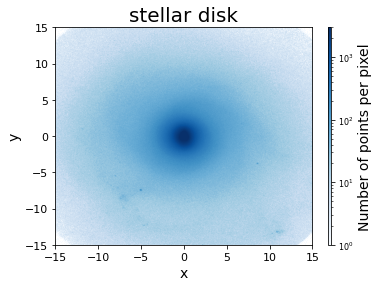

In [24]:
density_plot(part['star'].prop('host.distance.principal').T[0][idxs_star],
             part['star'].prop('host.distance.principal').T[1][idxs_star],
             xlabel='x', ylabel='y', name='xy.png', axlim=[[-15, 15], [-15, 15]],
             clim=[1, 3000], bins=512)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


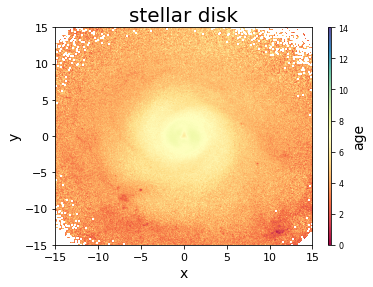

In [25]:
#%% 2d hist + age
density_plot(part['star'].prop('host.distance.principal').T[0][idxs_star],
             part['star'].prop('host.distance.principal').T[1][idxs_star],
             c=part['star'].prop('age')[idxs_star],
             xlabel='x', ylabel='y', name='xy_age.png', axlim=[[-15, 15], [-15, 15]],
             clim=[0, 14], stretch='lin', bins=512, cmap='Spectral', clabel='age')

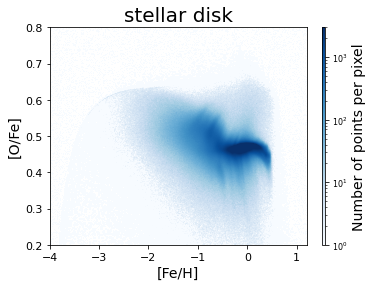

In [27]:
#%% 2d hist FeH-OFe
density_plot(part['star'].prop('metallicity.fe')[idxs_star],
             part['star'].prop('metallicity.o-metallicity.fe')[idxs_star],
             xlabel='[Fe/H]', ylabel='[O/Fe]', name='feh_ofe_80kpc.png', axlim=[[-4, 1.2], [0.2, 0.8]],
             clim=[1, 3000], bins=512)

# t-SNE

In [28]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500, learning_rate=1000,
            random_state=42)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 14170 samples in 0.025s...
[t-SNE] Computed neighbors for 14170 samples in 1.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14170
[t-SNE] Computed conditional probabilities for sample 2000 / 14170
[t-SNE] Computed conditional probabilities for sample 3000 / 14170
[t-SNE] Computed conditional probabilities for sample 4000 / 14170
[t-SNE] Computed conditional probabilities for sample 5000 / 14170
[t-SNE] Computed conditional probabilities for sample 6000 / 14170
[t-SNE] Computed conditional probabilities for sample 7000 / 14170
[t-SNE] Computed conditional probabilities for sample 8000 / 14170
[t-SNE] Computed conditional probabilities for sample 9000 / 14170
[t-SNE] Computed conditional probabilities for sample 10000 / 14170
[t-SNE] Computed conditional probabilities for sample 11000 / 14170
[t-SNE] Computed conditional probabilities for sample 12000 / 14170
[t-SNE] Computed conditional probabilities for sa

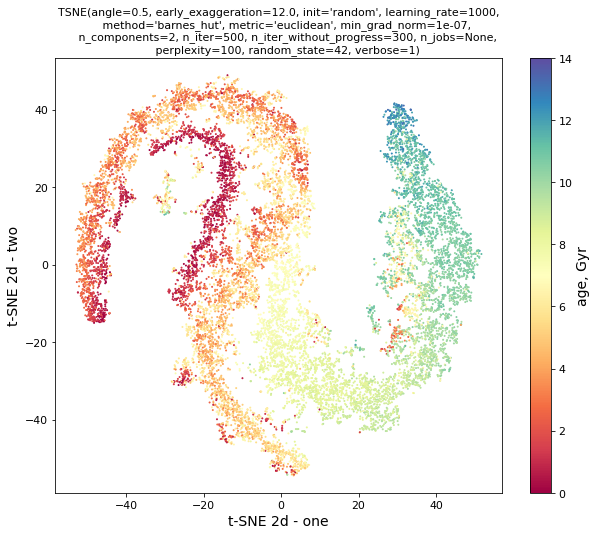

In [29]:
plot_results(tsne_results, ages, 'age, Gyr', method=str(tsne), clim=[0., 14.])

# UMAP

In [30]:
reducer = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.01, metric='minkowski', n_components=2)
reducer.fit(data_subset)

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='minkowski',
     metric_kwds=None, min_dist=0.01, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=20, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)

In [31]:
embedding = reducer.transform(data_subset)

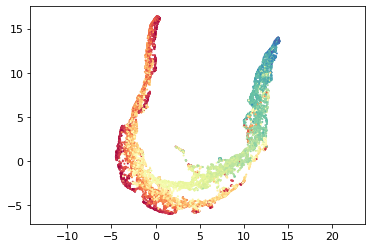

In [32]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=ages, cmap='Spectral', s=1)
plt.gca().set_aspect('equal', 'datalim')

# DBSCAN

In [35]:
clustering = DBSCAN(eps=0.01, min_samples=5).fit(data_subset)

In [39]:
len(set(clustering.labels_))  # number of clusters

66

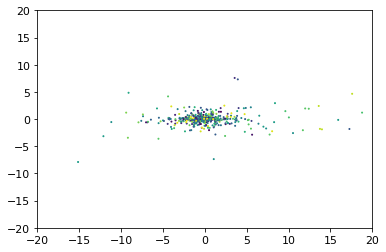

In [36]:
plt.figure()
plt.scatter(x[clustering.labels_>1], z[clustering.labels_>1], c=clustering.labels_[clustering.labels_>1], s=1.)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()
plt.close()